In [84]:
import sys
sys.path.append("..")
import functools

import numpy as np
import torch
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt
from dict_minimize.torch_api import minimize
import functorch

import pyequion2

In [85]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
torch.relu

<function torch._VariableFunctionsClass.relu>

In [322]:
torch.arange(2)[[1, 0], None]

tensor([[1],
        [0]])

In [566]:
class TransportBuilder(object):
    def __init__(self, eqsys, TK, shear_velocity, kinematic_viscosity, cbulk, phases,
                 kreaction="inf"):
        self.eqsys = eqsys
        self.TK = TK
        self.shear_velocity = shear_velocity
        self.kinematic_viscosity = kinematic_viscosity
        self.cbulk = cbulk
        self.phases = phases
        self.kreaction = kreaction
        self.simplified = False
        self.idealized = False
        
    def set_species(self, species_to_remove=[]):
        self.basedict = {k: v
                         for k, v in pyequion2.datamods.chemical_potentials.items()
                         if k in self.eqsys.solutes
                         and k not in species_to_remove}
        self.species = [spec for spec in eqsys.species[1:] if spec not in species_to_remove]
        self.species_ind = [eqsys.species.index(spec) for spec in self.species]
        self.solid_ind = [eqsys.solid_phase_names.index(phase) for phase in self.phases]
        self.reduced_formula_matrix = self.eqsys.formula_matrix[2:, self.species_ind]
        self.reduced_stoich_matrix = self.eqsys.stoich_matrix[:, self.species_ind]
        self.logk = eqsys.get_log_equilibrium_constants(self.TK)
        self.reduced_reaction_vector = \
            eqsys.solid_stoich_matrix[self.solid_ind, :][:, self.species_ind]
        self.nonconserved = torch.any(builder.reduced_formula_matrix@builder.reduced_reaction_vector.T != 0, dim=-1)
        self.nonconserved_inds = [i for i, c in enumerate(self.nonconserved) if c]
        self.conserved_inds = [i for i, c in enumerate(self.nonconserved) if not c]
        self.closure_matrix = torch.tensor(
            scipy.linalg.null_space(
                (self.reduced_formula_matrix@(self.reduced_reaction_vector.T)).T
            ).T
        )
        self.nspecies = len(self.species)
        self.logk_solid = self.eqsys.get_solid_log_equilibrium_constants(self.TK)[self.solid_ind]
        self.reduced_standard_potentials = self.eqsys.get_standard_chemical_potentials(self.TK)[self.species_ind]
        self.reduced_standard_potentials /= (pyequion2.constants.GAS_CONSTANT*self.TK)    
        self.reduce_activity_function()
        self.reduced_diffusion_coefficients = pyequion2.equilibrium_backend.diffusion_coefficients.get_diffusion_coefficients(
                                        self.species, self.TK)
        self.reduced_diffusion_coefficients = torch.tensor(self.reduced_diffusion_coefficients, dtype=torch.float)/self.kinematic_viscosity
        
    def reduce_activity_function(self):
        activity_model = eqsys.activity_model
        self._actfunc = pyequion2.equilibrium_backend.ACTIVITY_MODEL_MAP[activity_model](
                            self.species, backend="torch")
        
    def activity_model_func(self, molals, TK):
        if self.idealized:
            return torch.zeros_like(molals)
        else:
            return self._actfunc(molals, TK)[..., 1:]/pyequion2.constants.LOG10E
        
    def make_grid(self, ngrid, ymax):
        self.ngrid = ngrid
        self.npoints = ngrid + 1
        self.ymax = ymax
        self.ypoints = torch.linspace(0, self.ymax, self.npoints)
        self.ystep = self.ypoints[1] - self.ypoints[0]
        self.ygrid = self.ypoints[:-1] + self.ystep/2
        
    def wall_diffusion_plus(self, yplus):
        return 9.5*1e-4*yplus**3
    
    def wall_diffusion_plus_deriv(self, yplus):
        return 3*9.5*1e-4*yplus**2

    def transport_residual(self, logc):
        #logc : (nsolutes, ngrid)
        #npoints = ngrid + 1
        logg = self.activity_model_func(torch.exp(logc).T, self.TK).T #(nsolutes, ngrid)
        c = torch.exp(logc) #(nsolutes, ngrid)
        loga = logg + logc #(nsolutes, ngrid)
        ypoints = self.ypoints #(npoints,)
        ystep = self.ystep
        mdiffs = self.reduced_diffusion_coefficients[..., None] #(nsolutes, 1)
        mdiffs = torch.mean(mdiffs) + 0.0*mdiffs
        tdiffs = self.wall_diffusion_plus(ypoints)[1:-1] #(ngrid-1,)
        A = self.reduced_formula_matrix #(nels, nsolutes)
        C = self.closure_matrix #(nnoncon-nreac, nsolutes)
        R = self.reduced_reaction_vector #(nreac, nsolutes)
        logKsp = self.logk_solid[..., None] #(nreac, 1)
        cbulk = self.cbulk[:, None] #(nels, 1)
        cinterp = (c[:, 1:] + c[:, :-1])*0.5 #(nsolutes, ngrid-1)
        dmu = (loga[:, 1:] - loga[:, :-1])/ystep #(nsolutes, ngrid-1)
        dc = (c[:, 1:] - c[:, :-1])/ystep #(nsolutes, ngrid-1)
        if self.simplified:
            jmiddle = -A@(mdiffs*dc + tdiffs*dc) #(nels, ngrid-1)
        else:
            jmiddle = -A@(mdiffs*cinterp*dmu + tdiffs*dc) #(nels, ngrid-1)
        jleft = jmiddle[:, :1] #(nels, 1)
        cright = c[:, -1:] #(nsolutes, 1)
        logaleft = loga[:, :1] #(nsolutes, 1)
        middle_residual = jmiddle[:, 1:] - jmiddle[:, :-1] #(nels, ngrid-2)
        right_residual = A@cright - cbulk #(nsolutes, 1)
        if self.kreaction == "inf":
            upper_left_residual = R@logaleft - logKsp #(nreac, 1)
            lower_left_residual = C@(jleft) #(nnoncon - nreac, 1)
            left_residual = torch.cat([upper_left_residual, lower_left_residual], dim=0) #(nsolutes, 1)
        else:
            logsatur = R@logaleft - logKsp #(nreac, 1)
            jsatur = -self.kreaction*torch.relu(torch.exp(logsatur) - 1) #(nreac, 1)
            jend = A@(R.T)@jsatur #(nels, 1)
            left_residual = jend - jleft #(nels, 1)
        residual = torch.cat([left_residual, middle_residual, right_residual], dim=1) #(nsolutes, ngrid)
        return residual
    
    def fluxes(self, logc):
        #logc : (nsolutes, ngrid)
        #npoints = ngrid + 1
        logg = self.activity_model_func(torch.exp(logc).T, self.TK).T #(nsolutes, ngrid)
        c = torch.exp(logc) #(nsolutes, ngrid)
        loga = logg + logc #(nsolutes, ngrid)
        ypoints = self.ypoints #(npoints,)
        ystep = self.ystep
        mdiffs = self.reduced_diffusion_coefficients[..., None] #(nsolutes, 1)
        tdiffs = self.wall_diffusion_plus(ypoints)[1:-1] #(ngrid-1,)
        mdiffs = torch.mean(mdiffs) + 0.0*mdiffs
        A = self.reduced_formula_matrix #(nels, nsolutes)
        C = self.closure_matrix #(nnoncon-nreac, nsolutes)
        R = self.reduced_reaction_vector #(nreac, nsolutes)
        logKsp = self.logk_solid[..., None] #(nreac, 1)
        cbulk = self.cbulk[:, None] #(nels, 1)
        cinterp = (c[:, 1:] + c[:, :-1])*0.5 #(nsolutes, ngrid-1)
        dmu = (loga[:, 1:] - loga[:, :-1])/ystep #(nsolutes, ngrid-1)
        dc = (c[:, 1:] - c[:, :-1])/ystep #(nsolutes, ngrid-1)
        if self.simplified:
            jmiddle = -A@(mdiffs*dc + tdiffs*dc) #(nels, ngrid-1)
        else:
            jmiddle = -A@(mdiffs*cinterp*dmu + tdiffs*dc) #(nels, ngrid-1)
        return jmiddle    
        
    def potential_residual(self, logc, mu):
        #logc : (nsolutes, ngrid)
        #mu : (nsolutes, ngrid)
        logg = self.activity_model_func(torch.exp(logc).T, self.TK).T
        loga = logg + logc
        mu0 = self.reduced_standard_potentials[..., None]
        return mu - (mu0 + loga)
    
    def lma_residual(self, logc):
        logg = self.activity_model_func(torch.exp(logc).T, self.TK).T
        loga = logg + logc
        res = self.reduced_stoich_matrix@loga - self.logk[..., None]
        return res
    
    def full_residual(self, logcmu, lma=True, include_mu=False):
        #logcmu : (2*nsolutes, ngrid)
        if include_mu:
            n = logcmu.shape[0]
            logc = logcmu[:n//2, :]
            mu = logcmu[n//2:, :]
        else:
            logc = logcmu
        res1 = self.transport_residual(logc) #(nels, ngrid)
        if include_mu:
            res3 = self.potential_residual(logc, mu) #(nsolutes, ngrid)
        if lma:
            res2 = self.lma_residual(logc)
        if include_mu and lma:
            res = torch.cat([res1, res2, res3], dim=0)
        elif not include_mu and lma:
            res = torch.cat([res1, res2], dim=0)
        else:
            res = torch.cat([res1, res3], dim=0) #(nels + nreac, ngrid)
        return res

    def gibbs_free_energy(self, logcmu):
        n = logcmu.shape[0]
        logc = logcmu[:n//2, :]
        mu = logcmu[n//2:, :]
        c = torch.exp(logc)
        return torch.mean(torch.sum(c*mu, dim=0))    
    
    def wall_length(self):
        return self.kinematic_viscosity/self.shear_velocity
    
    def wall_time(self):
        return self.kinematic_viscosity/(self.shear_velocity**2)

    def get_log_equilibrium_constants(self, TK):
        return self.eqsys.get_log_equilibrium_constants(TK)

In [567]:
torch.any(builder.reduced_formula_matrix@builder.reduced_reaction_vector.T != 0, dim=-1)

tensor([ True,  True, False])

In [568]:
eqsys = pyequion2.EquilibriumBackend(["Na", "Cl"], from_elements=True, backend="torch", logbase="e",
                                     activity_model="IDEAL")

In [569]:
builder = TransportBuilder(eqsys, 298.15, 0.1, 1e-6,
                           torch.tensor([1.0, 1.0, 0.0]), ["Halite"],
                           kreaction="inf")
builder.make_grid(10, 5)
builder.set_species()
builder.simplified = True

In [570]:
logc = torch.ones([builder.nspecies, builder.ngrid])*0.0 - 0.0
mu = builder.reduced_standard_potentials[..., None] + logc
logcmu = torch.cat([logc, mu], axis=0).requires_grad_()

In [572]:
builder.full_residual(logc)

torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])


tensor([[-3.6151,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [32.6507, 32.6507, 32.6507, 32.6507, 32.6507, 32.6507, 32.6507, 32.6507,
         32.6507, 32.6507],
        [32.2241, 32.2241, 32.2241, 32.2241, 32.2241, 32.2241, 32.2241, 32.2241,
         32.2241, 32.2241]])

In [573]:
builder.idealized = True

def flat_residual(x):
    logcmu = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.full_residual(logcmu, lma=True, include_mu=False)
    return res.flatten()

def torch_wrap(f):
    def g(x):
        x = torch.tensor(x, dtype=torch.float)
        res = f(x).detach().numpy()
        return res
    return g
f = torch_wrap(flat_residual)
jac = torch_wrap(functorch.jacrev(flat_residual))

In [574]:
x0 = logc.flatten().detach().numpy()
solsimple = scipy.optimize.root(f, x0, jac=jac, method="lm")

torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])
torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9

In [575]:
# builder.idealized = False

# def flat_residual(x):
#     logcmu = x.reshape([builder.nspecies, builder.ngrid])
#     res = builder.full_residual(logcmu, lma=True, include_mu=False)
#     return res.flatten()

# def torch_wrap(f):
#     def g(x):
#         x = torch.tensor(x, dtype=torch.float)
#         res = f(x).detach().numpy()
#         return res
#     return g
# f = torch_wrap(flat_residual)
# jac = torch_wrap(functorch.jacrev(flat_residual))

# sol = scipy.optimize.root(f, solsimple.x, jac=jac, method="lm")
sol = solsimple

In [576]:
logcmu = solsimple.x.reshape(builder.nspecies, builder.ngrid)
logc = logcmu[:builder.nspecies, :]
c = np.exp(logc)

In [577]:
(builder.reduced_formula_matrix.numpy()@c)[-1, :]

array([ 3.00414548e-07,  1.32273385e-07,  3.47281601e-07,  6.17682070e-07,
        1.59952414e-07, -6.10225349e-09, -1.53114684e-08,  2.40036976e-09,
        2.10131339e-08, -6.08569863e-08])

In [578]:
builder.fluxes(torch.tensor(logc, dtype=torch.float))[-1, :]

tensor([ 4.3594e-09, -3.0084e-09, -6.4508e-09,  1.2901e-08,  4.2561e-09,
         1.0253e-09, -9.2490e-10, -1.1834e-08,  2.2604e-08])

In [579]:
builder.full_residual(torch.tensor(logc, dtype=torch.float), lma=True, include_mu=False)

torch.Size([5, 1])
torch.Size([5, 9])
torch.Size([9])
torch.Size([3, 5])


tensor([[ 0.0000e+00,  2.7940e-09,  4.6566e-09, -1.9558e-08,  3.7253e-09,
          1.2107e-08,  1.8626e-09, -1.8626e-08,  1.6764e-08,  0.0000e+00],
        [ 2.1868e-09, -6.5193e-09, -9.3132e-10,  1.4901e-08, -2.7940e-09,
         -2.7940e-09,  9.3132e-10, -1.8626e-09, -8.3819e-09,  0.0000e+00],
        [ 4.3594e-09, -7.3678e-09, -3.4424e-09,  1.9352e-08, -8.6447e-09,
         -3.2308e-09, -1.9502e-09, -1.0909e-08,  3.4438e-08,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [580]:
sol.success

True

Text(0.5, 0, '$y^+$')

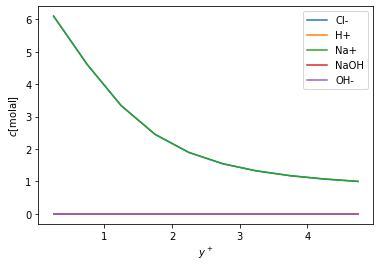

In [581]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

In [519]:
builder.reduced_formula_matrix.numpy()@np.exp(logc)

array([[ 6.79594396e+00,  4.31382878e+00,  2.73625485e+00,
         1.94316502e+00,  1.54024852e+00,  1.31777541e+00,
         1.18440565e+00,  1.09885518e+00,  1.04093808e+00,
         9.99999997e-01],
       [ 5.46701483e+00,  3.79312402e+00,  2.58599675e+00,
         1.89890973e+00,  1.52527805e+00,  1.31203350e+00,
         1.18203655e+00,  1.09788643e+00,  1.04061458e+00,
         1.00000002e+00],
       [ 1.32892888e+00,  5.20704584e-01,  1.50257975e-01,
         4.42552066e-02,  1.49704134e-02,  5.74187217e-03,
         2.36906272e-03,  9.68721858e-04,  3.23469802e-04,
        -4.25810476e-08]])

In [ ]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

In [ ]:
builder.full_residual(torch.tensor(logc, dtype=torch.float), lma=True, include_mu=False)